In [40]:
import pandas as pd
import folium
import numpy as np
from plots.Folium_heat import *
from plots.Folium_heat_time import *
import webbrowser

In [41]:
df = pd.read_pickle("data/final_final_final_data.pkl")
df.head()

,index,Unnamed: 0,Unnamed: 0.1,id,geom,addressRepresentation,beginLifeSpanVersion,buildingNature,conditionOfConstruction,connectionToGas,...,Kvadratmeterpris,Antal til salg pr. indbygger,Gennemsnitslig husleje,Kommuneskat,Grundskyld,Bruttoledige,Gæld,Pensionsopsparing,YearOfConstruction_Interval,YearOfRenovation_Interval
0,0,0,1878,1881,GP,"Elledamsvej 5, 2840 Holte",2015-01-05T16:29:11.950,other,functional,other:unpopulated,...,37466,0.0107,936,0.3521,22.930‰,0.0817,1806779,1772259,1931-1940,NaN
1,1,1,1878,1881,GP,"Elledamsvej 5, 2840 Holte",2015-01-05T16:29:11.950,other,functional,other:unpopulated,...,37466,0.0107,936,0.3521,22.930‰,0.0817,1806779,1772259,1931-1940,NaN
2,2,2,3028,3031,GP,"Vejlesøvej 36, 2840 Holte",2015-01-05T17:04:27.490,other,functional,other:unpopulated,...,37466,0.0107,936,0.3521,22.930‰,0.0817,1806779,1772259,1901-1910,NaN
3,3,3,5733,5736,GP,"Parcelvej 53, 2840 Holte",2015-01-05T16:47:42.557,other,functional,other:unpopulated,...,37466,0.0107,936,0.3521,22.930‰,0.0817,1806779,1772259,1921-1930,NaN
4,4,4,8093,8096,GP,"Vejlemosevej 4F, 2840 Holte",2016-10-20T16:00:12.350,other,functional,other:unpopulated,...,37466,0.0107,936,0.3521,22.930‰,0.0817,1806779,1772259,1931-1940,NaN


# Predictions

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *

In [55]:
def metrics(Y_test,y_pred,x_val,model):
    y_pred=y_pred
    x_val=x_val
    model=model
    auc=round(accuracy_score(Y_test,y_pred),4)
    f_score=round(f1_score(Y_test, y_pred),4)
    P_score=round(precision_score(Y_test,y_pred),4)
    recall=round(recall_score(Y_test, y_pred),4)
    
    ns_probs = [0 for _ in range(len(Y_test))]
    lr_probs = model.predict_proba(x_val)
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(Y_test, ns_probs)
    lr_auc = round(roc_auc_score(Y_test, lr_probs),4)
    return [auc,f_score,P_score,recall,lr_auc]

def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = importance
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df[fi_df.feature_importance > 0.01]
    

    #Define size of bar plot
    plt.figure(figsize=(8,6))
    plt.tight_layout()
    plt.yticks(fontsize=7)
    #Plot Searborn bar chart
    ax=sns.barplot(y='feature_names',x='feature_importance',data=fi_df,palette="rocket")
    ax.set_xlabel('feature_importance')
    #plt.xticks(rotation = 90)
    
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE > 0.01')
    plt.ylabel('FEATURE NAMES')


def evaluation_time(y_test,y_pred,model,x_val):
    ns_probs = [0 for _ in range(len(y_test))]
    lr_probs = model.predict_proba(x_val)
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print(f"Test set accuracy score {(np.round(accuracy_score(y_pred,y_test),3)*100)}%")
    print(f"F1 score {np.round(f_score,3)}")
    print(f"Recall score {np.round(recall,3)}")
    print(f"Precision score {np.round(P_score,3)}")
    print('Model: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Base')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='XGBoost')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

def evaluation(y_test,y_pred,model_xg,x_val):
    plt.style.use('ggplot')
    cm = confusion_matrix(y_test, (y_pred))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt='g',cmap='rocket'); #annot=True to annotate cells

    ax.set_xlabel('Predcited Winner');ax.set_ylabel('Actual Winner'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Server', 'Returner']); ax.yaxis.set_ticklabels(['Server', 'Returner'], rotation=360);
    plt.show()

    f_score=f1_score(y_test, y_pred, average=None)
    P_score=precision_score(y_test,y,average=None)
    recall=recall_score(y_test, y_pred, average=None)


    ns_probs = [0 for _ in range(len(y_test))]
    lr_probs = model_xg.predict_proba(x_val)
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print(f"Test set accuracy score {np.round(val_scoreXG*100,3)}%")
    print(f"F1 score {np.round(f_score,3)}")
    print(f"Recall score {np.round(recall,3)}")
    print(f"Precision score {np.round(P_score,3)}")
    print('Xgboost: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Base')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='XGBoost')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    
    results = model_xg.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)
    # plot log loss
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
    ax.legend()
    plt.ylabel('Log Loss')
    plt.title('XGBoost Log Loss')
    plt.show()
    # plot classification error
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['error'], label='Train')
    ax.plot(x_axis, results['validation_1']['error'], label='Test')
    ax.legend()
    plt.ylabel('Classification Error')
    plt.title('XGBoost Classification Error')
    plt.show()
    return


In [44]:
pred_df = df.drop_duplicates(subset=['addressRepresentation'],keep='last')
pred_df

,index,Unnamed: 0,Unnamed: 0.1,id,geom,addressRepresentation,beginLifeSpanVersion,buildingNature,conditionOfConstruction,connectionToGas,...,Kvadratmeterpris,Antal til salg pr. indbygger,Gennemsnitslig husleje,Kommuneskat,Grundskyld,Bruttoledige,Gæld,Pensionsopsparing,YearOfConstruction_Interval,YearOfRenovation_Interval
1,1,1,1878,1881,GP,"Elledamsvej 5, 2840 Holte",2015-01-05T16:29:11.950,other,functional,other:unpopulated,...,37466,0.0107,936,0.3521,22.930‰,0.0817,1806779,1772259,1931-1940,NaN
2,2,2,3028,3031,GP,"Vejlesøvej 36, 2840 Holte",2015-01-05T17:04:27.490,other,functional,other:unpopulated,...,37466,0.0107,936,0.3521,22.930‰,0.0817,1806779,1772259,1901-1910,NaN
3,3,3,5733,5736,GP,"Parcelvej 53, 2840 Holte",2015-01-05T16:47:42.557,other,functional,other:unpopulated,...,37466,0.0107,936,0.3521,22.930‰,0.0817,1806779,1772259,1921-1930,NaN
4,4,4,8093,8096,GP,"Vejlemosevej 4F, 2840 Holte",2016-10-20T16:00:12.350,other,functional,other:unpopulated,...,37466,0.0107,936,0.3521,22.930‰,0.0817,1806779,1772259,1931-1940,NaN
7,7,7,263014,263017,NaN,"Kollemosevej 27A, 2840 Holte",2000-02-05T21:01:47,other,demolished,other:unpopulated,...,37466,0.0107,936,0.3521,22.930‰,0.0817,1806779,1772259,2011-,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123055,106046,106046,5135511,5135514,GP,"Karise Alle 23, 2650 Hvidovre",2017-08-22T14:55:24.737,storage Tank,demolished,other:unpopulated,...,30356,0.0030,895,0.3837,29.700‰,0.1096,679388,830552,1961-1970,NaN
123056,106047,106047,4971033,4971036,GP,"Catherine Boothsvej 18D, 2650 Hvidovre",2021-06-30T09:09:41.177,other,under Construction,other:unpopulated,...,30356,0.0030,895,0.3837,29.700‰,0.1096,679388,830552,2011-,NaN
123057,106048,106048,4972335,4972338,GP,"Stamholmen 156, 2650 Hvidovre",2020-11-26T13:14:05.659,other,under Construction,other:unpopulated,...,30356,0.0030,895,0.3837,29.700‰,0.1096,679388,830552,2011-,NaN
123058,106049,106049,4980232,4980235,GP,"Catherine Boothsvej 18C, 2650 Hvidovre",2021-07-01T12:19:32.679,other,under Construction,other:unpopulated,...,30356,0.0030,895,0.3837,29.700‰,0.1096,679388,830552,2011-,NaN


In [45]:
X,y=[
              'connectionToSewage',
              'connectionToWater',
              'currentUse',
              'dateOfConstruction_dateOfEvent_anyPoint',
              'dateOfRenovation_dateOfEvent_anyPoint',
              'HeatSupply',
              'materialOfRoof',
              'materialOfWall',
              'YearOfConstruction_Interval',
              'has_been_rennovated'
              ],['EnergyLabelClassification']

In [46]:
has_been_rennovated=[]
for i in range(len(pred_df)):
    if df.dateOfRenovation_dateOfEvent_anyPoint[i] =="other:unpopulated":
        has_been_rennovated.append(0)
    else:
        has_been_rennovated.append(1)
pred_df['has_been_rennovated']=has_been_rennovated
    

<ipython-input-46-61ccf51ef3fd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['has_been_rennovated']=has_been_rennovated


In [47]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
pred_df=pred_df.sort_values(by=['EnergyLabelClassification'])
y=pred_df[y].values
x=pred_df[X]
x=pd.get_dummies(x)
labels=list(x.columns)
x=x.values
scaler = StandardScaler()
x=scaler.fit_transform(x)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

model_xg = XGBClassifier(objective ='binary:logistic')
model_xg.fit(X_train, y_train);
y_pred = model_xg.predict(X_test);

/Users/martinillum/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/martinillum/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[16:42:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [49]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = sorted(list(df.EnergyLabelClassification.unique())), 
                     columns = sorted(list(df.EnergyLabelClassification.unique())))

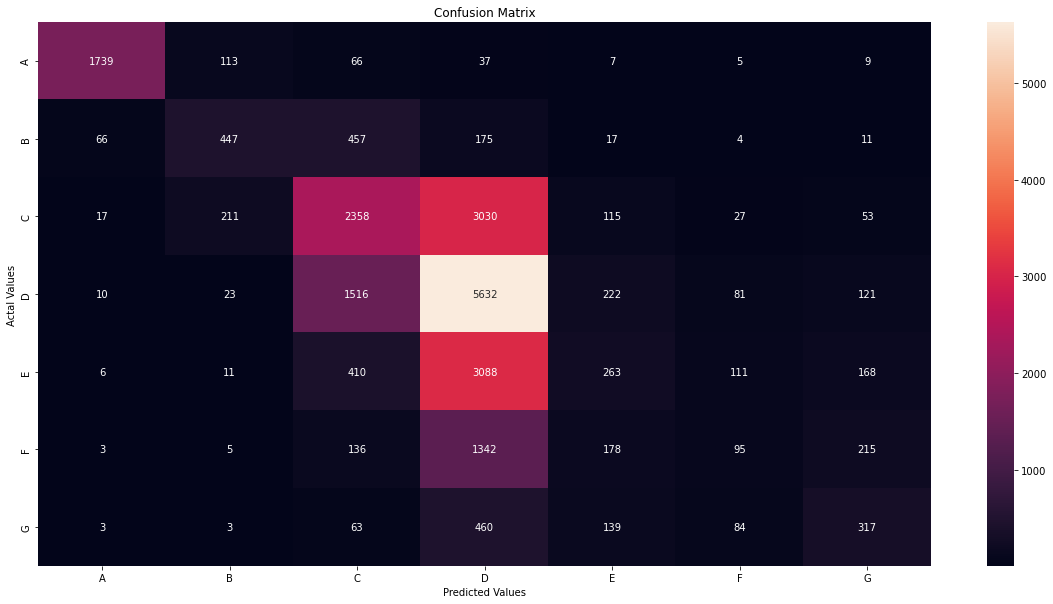

In [50]:
#Plotting the confusion matrix
plt.figure(figsize=(20,10))
sns.heatmap(cm_df, annot=True,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [51]:
scoreXG

0.46599359763605025

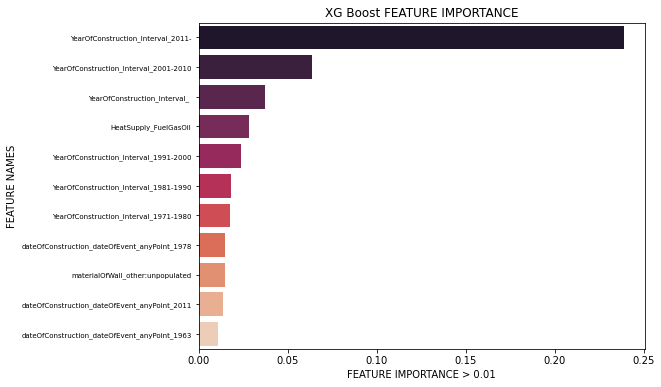

In [54]:
plot_feature_importance(model_xg.feature_importances_,labels,"XG Boost")

In [56]:
evaluation_time(y_test,y_pred,model_xg,X_test)

ValueError: multi_class must be in ('ovo', 'ovr')